In [162]:
def create_connection_vwall(amt, cx, cy, mh):
    return iter((cx, cy + mh * (n / (amt + 1) - 1/2)) for n in IntegerRange(1, amt + 1))

In [163]:
list(create_connection_vwall(1, 0, 0, 1))

[(0, 0)]

In [164]:
list(create_connection_vwall(2, 0, 0, 1))

[(0, -1/6), (0, 1/6)]

In [165]:
list(create_connection_vwall(3, 0, 0, 1))

[(0, -1/4), (0, 0), (0, 1/4)]

In [166]:
list(create_connection_vwall(4, 0, 0, 1))

[(0, -3/10), (0, -1/10), (0, 1/10), (0, 3/10)]

In [167]:
list(create_connection_vwall(5, 0, 0, 1))

[(0, -1/3), (0, -1/6), (0, 0), (0, 1/6), (0, 1/3)]

In [270]:
class MachineChart:
    
    def __init__(self, nodes, connections, max_col, col_amts):
        self.nodes = nodes
        self.connections = connections
        self.max_col = max_col
        self.col_amts = col_amts
    
    def create_connection_graphics_obj_multiline(self, coords, color):
        fig = Graphics()
        
        for i in range(len(coords) - 1):
            x, y = coords[i]
            nx, ny = coords[i + 1]
            fig += line(((x, y), (nx, ny)), rgbcolor = color)
        
        return fig
        
    
    def create_connection_graphics_obj(self, from_uid, to_uid, f, t, offset, color):
        fx, fy = f
        tx, ty = t
        
        fcol = self.nodes[from_uid][2]["column"]
        tcol = self.nodes[to_uid][2]["column"]
        
        if fcol + 1 == tcol:
            return self.create_connection_graphics_obj_multiline([(fx, fy), 
                                                                  (fx + 0.1 + offset, fy), 
                                                                  (fx + 0.1 + offset, ty), 
                                                                  (tx, ty)], color)
        else:
            passover_cols = list(range(fcol + 1, tcol))
            
            max_amt_rows = max(self.col_amts[i] for i in passover_cols)
            
            avoidanceY = sign(ty) * (max_amt_rows / 2  + 3 * offset)
            return self.create_connection_graphics_obj_multiline([(fx, fy), 
                                                                  (fx + 0.1 + offset, fy), 
                                                                  (fx + 0.1 + offset, avoidanceY), 
                                                                  (tx - 0.1 - offset, avoidanceY), 
                                                                  (tx - 0.1 - offset, ty), 
                                                                  (tx, ty)], color)
    
    def show(self):
        fig = Graphics()
        
        for uid in self.nodes:
            text_v, tpe, kws = self.nodes[uid]
            x = kws["column"]
            y = (self.col_amts[kws["column"]] - 1) / 2 - kws["row"]
            kws["from_points"] = create_connection_vwall(len(kws["outs"]), x + 0.25, y, 0.25) #iter(len(kws["outs"]) * [(kws["x"], kws["y"])])
            kws["to_points"] = create_connection_vwall(len(kws["ins"]), x - 0.25, y, 0.25) #iter(len(kws["ins"]) * [(kws["x"], kws["y"])])
            s = 0.25
            
            coords = []
            
            if tpe == "machine":
                coords = [(x - s, y - s), (x - s, y + s), (x + s, y + s), (x + s, y - s)]
            elif tpe == "input":
                coords = [(x - 2 * s, y), (x + s, y + s), (x + s, y - s)]
            elif tpe == "output":
                coords = [(x - s, y - s), (x - s, y + s), (x + 2 * s, y)]
            
            fig += polygon2d(coords, fill=False, rgbcolor="black") #rect((kws["x"], kws["y"]), 0.25)
            fig += text(text_v, (x, y), rgbcolor="black", vertical_alignment="center", horizontal_alignment="center")
        
        
        lc = len(self.connections)
        
        color_rotations = ["blue", "red", "green", "orange", "cyan", "purple"]
        
        for i, (from_uid, to_uid) in enumerate(self.connections):
            fx, fy = next(self.nodes[from_uid][2]["from_points"])
            tx, ty = next(self.nodes[to_uid][2]["to_points"])
            
            fig += self.create_connection_graphics_obj(from_uid, to_uid, (fx, fy), (tx, ty), 0.2 * i / lc, color_rotations[i % len(color_rotations)]) # line(((fx, fy), (tx, ty)))
        
        fig.axes(show = False)
        
        return fig
    
    def __repr__(self):
        return repr((self.nodes, self.connections, self.max_col, self.col_amts))
    

In [271]:
class MachineChartBuilder:
    
    def __init__(self):
        self.nodes = {}
        self.connections = []
        pass
    
    def add_input(self, uid, text, **kws):
        self.nodes[uid] = (text, "input", kws)
        return self
    
    def add_machine(self, uid, text, **kws):
        self.nodes[uid] = (text, "machine", kws)
        return self
        
    def add_output(self, uid, text, **kws):
        self.nodes[uid] = (text, "output", kws)
        return self
    
    def connect(self, from_uid, to_uid):
        if from_uid not in self.nodes or to_uid not in self.nodes:
            raise ValueError("Cannot find uids " + str((from_uid, to_uid)))
        if self.nodes[to_uid][1] == "input":
            raise ValueError("Cannot connect to input!")
        if self.nodes[from_uid][1] == "output":
            raise ValueError("Cannot connect from output!")
            
        self.connections.append((from_uid, to_uid))
        
        return self
    
    def build(self):
        # Assign x's and y's and in_count and out_count to nodes
        
        for uid in self.nodes:
            self.nodes[uid][2]["ins"] = []
            self.nodes[uid][2]["outs"] = []
            self.nodes[uid][2]["column"] = NaN
        
        for from_uid, to_uid in self.connections:
            self.nodes[from_uid][2]["outs"].append(to_uid)
            self.nodes[to_uid][2]["ins"].append(from_uid)
        
        for uid in self.nodes:
            _, tpe, kws = self.nodes[uid]
            
            if tpe == "input" and len(kws["outs"]) == 0:
                raise ValueError("Every input must be connected to something!")
            
            if tpe == "output" and len(kws["ins"]) == 0:
                raise ValueError("Every output must be connected to something!")
            
            if tpe == "machine" and (len(kws["outs"]) == 0 or len(kws["ins"]) == 0):
                raise ValueError("Every machine must have connections on both sides!")
        
        remaining = list(self.nodes)
        
        max_col = 0
        
        while len(remaining) > 0:
            uid = remaining.pop(0)
            _, tpe, kws = self.nodes[uid]
            if tpe == "input":
                kws["column"] = 0
            else:
                in_cols = [self.nodes[uid][2]["column"] for uid in kws["ins"]]
                if all(c != NaN for c in in_cols):
                    ncol = max(in_cols) + 1
                    kws["column"] = ncol
                    if ncol > max_col:
                        max_col = ncol
                else:
                    remaining.append(uid)
              
        for uid in self.nodes:
            _, tpe, kws = self.nodes[uid]
            if tpe == "output":
                kws["column"] = max_col
        
        col_amts = {col: 0 for col in range(0, 1 + max_col)}
        
        for uid in self.nodes:
            _, tpe, kws = self.nodes[uid]
            kws["row"] = col_amts[kws["column"]]
            col_amts[kws["column"]] += 1
                    
        return MachineChart(self.nodes, self.connections, max_col, col_amts)
    

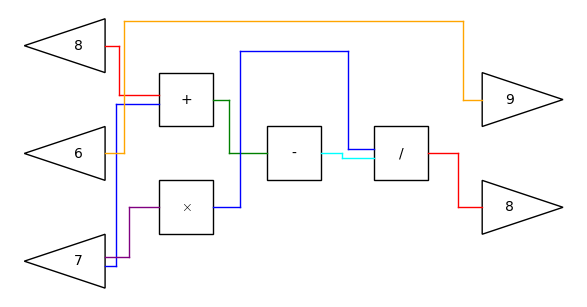

In [272]:
(MachineChartBuilder()
    .add_input("i3", "8")
    .add_input("i1", "6")
    .add_input("i2", "7")
    .add_machine("m1", "+")
    .add_machine("m2", "-")
    .add_machine("m3", r"$\times$")
    .add_machine("m4", "/")
    .add_output("o1", "9")
    .add_output("o2", "8")
    .connect("i2", "m1")
    .connect("i3", "m1")
    .connect("m1", "m2")
    .connect("i1", "o1")
    .connect("m2", "m4")
    .connect("i2", "m3")
    .connect("m3", "m4")
    .connect("m4", "o2")
    .build()).show()

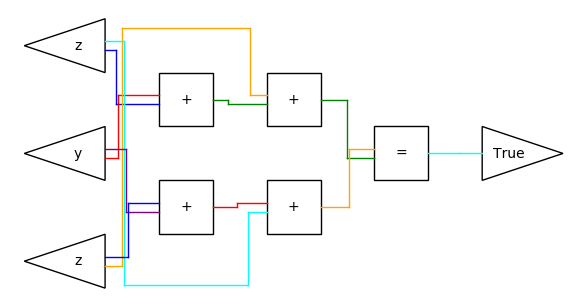

In [273]:
(MachineChartBuilder()
    .add_input("x", "z")
    .add_input("y", "y")
    .add_input("z", "z")
    .add_machine("lm1", "+")
    .add_machine("lm2", "+")
    .add_machine("rm1", "+")
    .add_machine("rm2", "+")
    .add_machine("me", "=")
    .add_output("o", "True")
    .connect("x", "lm1")
    .connect("y", "lm1")
    .connect("lm1", "lm2")
    .connect("z", "lm2")
    .connect("x", "rm2")
    .connect("y", "rm1")
    .connect("z", "rm1")
    .connect("rm1", "rm2")
    .connect("lm2", "me")
    .connect("rm2", "me")
    .connect("me", "o")
    .build()).show()

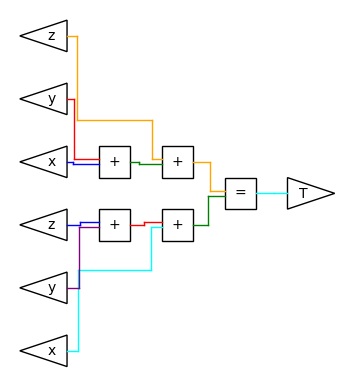

In [275]:
(MachineChartBuilder()
    .add_input("lz", "z")
    .add_input("ly", "y")
    .add_input("lx", "x")
    .add_input("rz", "z")
    .add_input("ry", "y")
    .add_input("rx", "x")
    .add_machine("lm1", "+")
    .add_machine("lm2", "+")
    .add_machine("rm1", "+")
    .add_machine("rm2", "+")
    .add_machine("me", "=")
    .add_output("o", "T")
    .connect("lx", "lm1")
    .connect("ly", "lm1")
    .connect("lm1", "lm2")
    .connect("lz", "lm2")
    .connect("rx", "rm2")
    .connect("ry", "rm1")
    .connect("rz", "rm1")
    .connect("rm1", "rm2")
    .connect("rm2", "me")
    .connect("lm2", "me")
    .connect("me", "o")
    .build()).show()

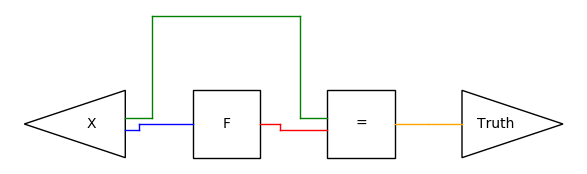

In [279]:
(MachineChartBuilder()
    .add_machine("me", "=")
    .add_input("x", "X")
    .add_machine("f", "F")
    .add_output("o", "Truth")
    .connect("x", "f")
    .connect("f", "me")
    .connect("x", "me")
    .connect("me", "o")
    .build()).show()